<a href="https://colab.research.google.com/github/R09722akaBennett/Side_Project/blob/master/NLP_execise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Preprocessing ,Import package **

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟

Mounted at /content/gdrive


In [ ]:
# install package
!pip install monpa
!pip install wordcloud

     |████████████████████████████████| 8.5 MB 4.7 MB/s 


In [ ]:
# import package
import csv
import monpa
from monpa import utils
import pandas as pd
from collections import Counter
import numpy
import wordcloud # 文字雲
from PIL import Image
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier   
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


### **Keyword Extraction-列出漲停及跌停文件中最具鑑別力的詞彙：每一類各列出100個詞彙，依鑑別力由高至低排列**

In [ ]:
# Import doc and Generate TF, DF, article_num, segmentation
def counter_df_tf_articleNum(path_in,counter_tf,counter_df,num,segmentation):
   # 打開語料庫
    f1 = open(path_in, 'r', newline='',encoding='utf-8')
    rows = csv.reader(f1, delimiter=',')
    ## 進行斷詞
    i = 0
    num = 0
    for row in rows:
        i += 1
        if i > 1:
            query = row[0] + ' ' + row[1]
            num += 1
            df_tmp=Counter() #暫存本篇df用
            segment = ''  # 暫存斷詞結果
            sentence_list = utils.short_sentence(query)
            for item in sentence_list:
                result_cut = monpa.cut(item)
                for term in result_cut:
                    term = term.strip()
                    if len(term) > 1:
                        counter_tf[term]+=1
                        segment = segment + ' ' + term
                        if(df_tmp[term]==0): #若本篇之前不曾出現
                          df_tmp[term]=1 #df標為1
            counter_df+=df_tmp # 累加多篇df
            segmentation.append(segment)
    f1.close()
    return counter_tf, counter_df, num,segmentation

In [ ]:
# Generate Mutual Information
def counter_mi(tf_counter_up,df_counter_up,num_up,tf_counter_down,df_counter_down,num_down,mi_counter_up,mi_counter_down):
  for i in tf_counter_up.keys():
    i_in_all_article= df_counter_up[i] + df_counter_down[i]
    mi = numpy.log10((df_counter_up[i]/(i_in_all_article*num_up)))
    mi_counter_up[i]= mi
  for i in tf_counter_down.keys():
    i_in_all_article= df_counter_up[i] + df_counter_down[i]
    mi = numpy.log10((df_counter_down[i]/(i_in_all_article*num_down)))
    mi_counter_down[i]= mi
  return mi_counter_up, mi_counter_down

In [ ]:
# Merge dict and count TF-IDF, TF-IDF*MI
def merge_dataframe(df_counter,tf_counter,mi_counter,num):
  df = pd.merge(pd.merge(pd.DataFrame(list(df_counter.items()),
                    columns=['Term', 'DF']), 
                  pd.DataFrame(list(tf_counter.items()),
                    columns=['Term', 'TF'])),
                pd.DataFrame(list(mi_counter.items()),
                    columns=['Term', 'MI']))
  df["TF-IDF"] = (1 + numpy.log10(df["TF"])) * (numpy.log10((num/df["DF"]))).astype(float)
  df["TF-IDF*MI"] = df["TF-IDF"] * df["MI"]
  return df

In [ ]:
# Data Cleaning
# 清除 TF and DF <=2，清除含的數字關鍵字，並取前200列關鍵字
def df_clean(df):
  df = df[~df['Term'].str.contains(r'[\d.]')]
  df = df.drop(
      df[
         (df.TF == 1) & (df.DF == 1)|
         (df.TF == 2) & (df.DF == 2)
         ].index)
  df = df.sort_values(by="TF-IDF*MI", ascending=False).head(200)
  return df

# Generate intersection words from two dataframe 
def find_intersection(df1,df2):
  intersection = [x for x in df1.Term.values for y in df2.Term.values if x == y]
  return intersection

# remove top intersection words in dataframe
def remove_duplicate(df,intersection):
  df = df[~df['Term'].isin(intersection)]
  return df

# list top common term 100
def top_common_term(df):
  df = df.head(100)
  return df


In [ ]:
# 匯出關鍵字
def path_out(path_out,df):
  df.to_csv(path_out,header=False)
  return print("Export Done")

In [ ]:
data_up = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_up.csv"
data_up_term = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_up_term.csv"
data_down = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_down.csv"
data_down_term = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_down_term.csv"

In [ ]:
# Generate tf df and mi
segmentation = []
tf_counter=Counter()
df_counter= Counter()
num = 0
tf_counter_up,df_counter_up,num_up,segmentation_up=counter_df_tf_articleNum(data_up,tf_counter,df_counter,num,segmentation)
tf_counter=Counter()
df_counter= Counter()
num = 0
tf_counter_down,df_counter_down,num_down,segmentation_down=counter_df_tf_articleNum(data_down,tf_counter,df_counter,num,segmentation)
mi_counter_up = Counter()
mi_counter_down = Counter()
mi_counter_up,mi_counter_down = counter_mi(tf_counter_up,df_counter_up,num_up,tf_counter_down,df_counter_down,num_down,mi_counter_up,mi_counter_down)

/usr/local/lib/python3.7/dist-packages/monpa/crf_layer.py:374: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [ ]:
# Merge dataframe
df_up = merge_dataframe(df_counter_up,tf_counter_up,mi_counter_up,num_up)
df_down = merge_dataframe(df_counter_down,tf_counter_down,mi_counter_down,num_down)

In [ ]:
df_down = df_down[~df_down['Term'].str.contains(r'[\d.]')]
df_down.sort_values(by="TF-IDF*MI", ascending=False)

,Term,DF,TF,MI,TF-IDF,TF-IDF*MI
2,跌停,123,367,-2.171833,0.037306,-0.081022
19,股價,89,246,-2.880145,0.511965,-1.474534
118,台北,70,86,-2.847449,0.749097,-2.133015
116,記者,67,67,-2.849484,0.775180,-2.208864
545,市場,70,154,-2.788027,0.813686,-2.268580
...,...,...,...,...,...,...
1995,立積,1,15,-2.577492,4.570598,-11.780679
4939,板塊,1,4,-3.691435,3.364920,-12.421383
4897,富邦媒,1,7,-3.214314,3.875390,-12.456719
3398,周三,1,12,-2.878522,4.367051,-12.570652


In [ ]:
# 清除 TF and DF <=2，清除含的數字關鍵字，並取前200列關鍵字
df_up = df_clean(df_up)
df_down = df_clean(df_down)

#Generate intersection
intersection = find_intersection(df_up,df_down)

#remove top intersection words in dataframe
df_up = remove_duplicate(df_up,intersection)
df_down = remove_duplicate(df_down,intersection)

In [ ]:
intersection

['股價',
 '持續',
 '台北',
 '記者',
 '今年',
 '時報',
 '報導',
 '市場',
 '目前',
 '公司',
 '表示',
 '表現',
 '獲利',
 '由於',
 '財訊',
 '法人',
 '預期',
 '開盤',
 '快報',
 '早盤',
 '今天',
 '指出',
 '客戶',
 '以來',
 '超過',
 '價格',
 '未來',
 '主要',
 '全球',
 '其中',
 '另外',
 '以及',
 '相關',
 'BR',
 '隨著',
 '不過',
 '中央社',
 '投資',
 '大幅',
 '新聞',
 '族群',
 '影響',
 '指數',
 '來源',
 '來到',
 '台股',
 '受到',
 '新台幣',
 '連續',
 '美國',
 '成交量',
 '第二',
 '因此',
 '高達',
 '公布',
 '中國']

In [ ]:
# list top 100 common term
df_up = top_common_term(df_up)
df_down = top_common_term(df_down)

In [ ]:
# export term
path_out(data_up_term,df_up.Term)
path_out(data_down_term,df_down.Term)
print(pd.DataFrame(df_up.Term))
print(pd.DataFrame(df_down.Term))

Export Done
Export Done
     Term
85     漲停
235    營收
53     新高
882    今日
335    成長
...   ...
321    應用
996    擴大
372   第四季
957   第三季
2366   編輯

[100 rows x 1 columns]
      Term
2       跌停
632     重挫
74      跌幅
23      賣壓
62      下跌
...    ...
2895    跌至
4687  跌跌不休
4455    香港
3534   交易商
1971    斷頭

[100 rows x 1 columns]


### **Text Similarity-實作「以文找文」的功能：自行任意給定一段文字，從全部的漲停及跌停文件中，挑選出最相似的3篇，依相似程度由高至低排序。**

In [ ]:
# import segmentation 
def import_seg(path_in,output):
  f = open(path_in, newline='', encoding='utf-8') #開檔 
  rows = csv.reader(f, delimiter=',') #讀檔
  for row in rows: 
    output.append(row[0])
  f.close()
  return output

In [ ]:
# import termset
def import_termset(path_in,termset,no):
  f = open(path_in, newline='', encoding='utf-8') #開檔 
  rows = csv.reader(f, delimiter=',') #讀檔
  for row in rows:
    if row[1] not in termset: #如果是新詞彙則加入(意思是重複的不列入)
      termset[row[1]]= no
      no+=1
  f.close()
  return termset , no

In [ ]:
# Generate vector space model and export
def vsm(termset,segmentation):
  vectorizer = TfidfVectorizer(vocabulary= termset, use_idf=True,lowercase=False)
  X = vectorizer.fit_transform(segmentation) #用給定的termset建構向量，並使用idf加權
  return X

In [ ]:
# cut text
def cut_text(text):
  str='' #暫存本篇斷詞後的內容用
  sentence_list = utils.short_sentence(text) #斷句
  for item in sentence_list:
    result_cut = monpa.cut(item) #斷詞
    for term in result_cut:
      term=term.strip() #去除前後多餘空白
      if(len(term)>1): #若詞長>1
        str=str+' '+term
  return str

In [ ]:
# find three of the most similar doc in segmentation
def similarity(str,termset,segmentation):
  vectorizer = TfidfVectorizer(vocabulary=termset, use_idf=True,lowercase=False)
  q = vectorizer.fit_transform([str]) #將查詢也套入同一個向量空間
  # print(q[0:1]) #印出該向量做觀察
  cosine_similarities = linear_kernel(q[0:1], X).flatten() #與給定文件集的向量做相似度計算
  # print(cosine_similarities) #印出與每一篇的相似度做觀察
  related_docs_indices = cosine_similarities.argsort() #將相似度由小至大做排序，並轉換成文件編號
  # print(related_docs_indices)
  d=related_docs_indices[:-4:-1] #從後面取5個文件編號 (也就是相似度最大的前3名)
  for i in d:
    print('doc ',i,' : '+segmentation[i]) #印出這些文件內容

In [ ]:
# Import termset
data_up_term = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_up_term.csv"
data_down_term = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_down_term.csv"
termset= dict()
no = 0
termset,no = import_termset(data_up_term,termset,no)
termset,no = import_termset(data_down_term,termset,no)


# Import npz file
# model_npz = "/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_model.npz"
X = vsm(termset,segmentation)


#給定任何一段內容當作查詢
test ='台股開高走低，買盤轉向具題材的網通族群。低軌衛星國家隊的耀登（3138）盤中攻上漲停201元價位，昇達科（3491）盤中也一度觸及200元關卡，創1月19日來新高。\
搭上低軌衛星成長商機的昇達科日前在法人說明會指出，低軌衛星寬頻網路可解決目前有線、無線行動通訊覆蓋率不足的問題，看好低軌衛星未來10年商機，今年業績成長10.5倍。\
昇達科掌握全球主要低軌衛星通訊業者訂單，包括SpaceX、OneWeb及AmazonKuiper，Telesat則是進入規格討論階段。\
昇達科今天盤中一度攻至200元價位，大漲5.54%，不過尾盤短線賣壓出籠，以193元作收，漲幅1.85%；昇達科子公司芮特-KY（6514）今天也獲買盤青睞，10時過後攻上73.8元漲停價位。\
而衛星通訊概念族群的台揚（2314）、建漢（3062）及譁裕（3419），也在中低價轉機題材下全面攻上漲停，以70.5元、28.95元及23.35元作收。\
其他網通族群方面，24日舉行法人說明會的合勤控（3704）今天收在30.55元，上漲2.69%；明泰（3380）、正文（4906）分別以32.5元及32.2元作收，漲幅1.4%及1.1%，\
合勤控在法說會中表示，今年訂單能見度高甚至看到年底，但塞港、長短料瓶頸仍待改善，成長力道有限，將優先活化庫存。\
明泰科技日前在法說會表示，2021年區域都會網路的產品線占比從27%增加至32%，受缺料衝擊較小，維持穩定出貨。400G交換器已準備就緒，今年以設計代工（ODM）為主，Wi-Fi6占整體Wi-Fi比重已達35%，Wi-Fi5占60%，其餘5%為Wi-Fi4產品。\
正文2021年因零組件價格上漲、新台幣及人民幣升值等因素，毛利率受影響而下滑，但全年度營收仍穩定向上。展望2022年零組件價格上漲壓力趨緩，加上新台幣回貶、高毛利率產品比重提升，有助於毛利率改善。'
similarity(cut_text(test),termset,segmentation)

doc  141  :  熱門 族群 聯發科 漲停 晶心科 揚智 亮燈 齊賀 時報 記者 王逸芯 台北 報導 聯發科 2454 上演 驚奇 第一 16.24 加上 未來 特別 股利 以及 營收 成長 40 超優 展望 股價 開盤 風光 攻上 漲停 鎖住 站穩 1185 10 00 停價 張數 2900 顯示 市場 熱絡 程度 聯發科 隨著 市占率 歐美 高階 規格 市場 持續 擴張 以及 滲透率 持續 上升 帶來 效益 今年 獲利 相當 機會 挑戰 新高 隨著 聯發科 漲停 帶動 概念股 揚智 3041 晶心科 6533 同樣 漲停 聯發科 昨日 舉行 法說會 首季 16.21 優於 市場 預期 預期 營收 至少 季增 一成 新猷 執行長 蔡力行 表示 現在 看到 成長 動能 今年 營收 增幅 至少 40 起跳 上調 毛利率 目標 44 46 聯發科 目前 訂單 需求 年初 預期 強勁 給出 2021年 營收 成長 40 以上 毛利率 區間 上升 44 46 展望 考量 手機 晶片 市占率 擴張 趨勢 持續 預期 歐美 市場 拿下 更多 市占 空間 重回 旗艦 產品 市場 加上 Wi-Fi 規格 升級 電源 管理 產品 需求 強勁 今年 獲利 機會 挑戰 新高 另外 昨日 法說會 驚奇 回饋 股東 長期 支持 聯發科 調整 配息 政策 過往 配息率 60 70 80 85 2021 2024 年度 加發 1000億 現金 股利 換言 股東 收到 16 現金 股利
doc  376  :  世界 先進 第3季 展望 樂觀 股價 奔漲 停創 天價 中央社 記者 張建中 新竹 2021年 8月 4日 世界 先進 第3季 營運 展望 樂觀 營收 115億 119億 可望 續創 歷史 新高 毛利率 44 46 世界 先進 今天 股價 表現 強勁 強攻 漲停 133.5 天價 受惠 手機 尺寸 面板 驅動 IC 客戶 晶圓 代工 需求 持續 成長 世界 先進 5347 預期 第3 營收 新台幣 115億 119億 中間值 117億 季增 15 歷史 新高 世界 先進 第3 晶圓 產能 增加 隨著 售價 調漲 產品 組合 產品 平均 售價 第2 上揚 11 13 毛利率 44 46 中間值 45 第2 拉升 分點 法人 預期 世界 先進 第3 獲利 可望 去年 倍增 單季 純益 

### **Auto-Tagging-實作「文件自動標記」的分類功能：自行任意給定一段文字，看內容較相似於漲停文件或跌停文件，進而決定應該標記為漲停及跌停類別。**

In [ ]:
def predict_doc(doc):
  classifier = DecisionTreeClassifier(criterion="entropy")
  classifier.fit(X,y) #訓練
  y_pred = classifier.predict(vsm(termset,[doc])) #預測
  print(y_pred)

In [ ]:
# X = sparse.load_npz("/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_model.npz") #讀入稀疏矩陣

# 已知 y
y=[] #用以儲存已知類別
for i in range(612): #已知前612篇為漲停，標記為看漲 (此為取巧權宜作法)
  y.append(['看漲'])
for i in range(126): #已知後126篇為跌停，標記為看跌
  y.append(['看跌'])


test ='台股開高走低，買盤轉向具題材的網通族群。低軌衛星國家隊的耀登（3138）盤中攻上漲停201元價位，昇達科（3491）盤中也一度觸及200元關卡，創1月19日來新高。\
搭上低軌衛星成長商機的昇達科日前在法人說明會指出，低軌衛星寬頻網路可解決目前有線、無線行動通訊覆蓋率不足的問題，看好低軌衛星未來10年商機，今年業績成長10.5倍。\
昇達科掌握全球主要低軌衛星通訊業者訂單，包括SpaceX、OneWeb及AmazonKuiper，Telesat則是進入規格討論階段。\
昇達科今天盤中一度攻至200元價位，大漲5.54%，不過尾盤短線賣壓出籠，以193元作收，漲幅1.85%；昇達科子公司芮特-KY（6514）今天也獲買盤青睞，10時過後攻上73.8元漲停價位。\
而衛星通訊概念族群的台揚（2314）、建漢（3062）及譁裕（3419），也在中低價轉機題材下全面攻上漲停，以70.5元、28.95元及23.35元作收。\
其他網通族群方面，24日舉行法人說明會的合勤控（3704）今天收在30.55元，上漲2.69%；明泰（3380）、正文（4906）分別以32.5元及32.2元作收，漲幅1.4%及1.1%，\
合勤控在法說會中表示，今年訂單能見度高甚至看到年底，但塞港、長短料瓶頸仍待改善，成長力道有限，將優先活化庫存。\
明泰科技日前在法說會表示，2021年區域都會網路的產品線占比從27%增加至32%，受缺料衝擊較小，維持穩定出貨。400G交換器已準備就緒，今年以設計代工（ODM）為主，Wi-Fi6占整體Wi-Fi比重已達35%，Wi-Fi5占60%，其餘5%為Wi-Fi4產品。\
正文2021年因零組件價格上漲、新台幣及人民幣升值等因素，毛利率受影響而下滑，但全年度營收仍穩定向上。展望2022年零組件價格上漲壓力趨緩，加上新台幣回貶、高毛利率產品比重提升，有助於毛利率改善。'

predict_doc(cut_text(test))

['看漲']


### **Model Selection-模型選擇**

In [ ]:
X = sparse.load_npz("/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_model.npz") #讀入稀疏矩陣
# 已知 y
y=[] #用以儲存已知類別
for i in range(612): #已知前612篇為漲停，標記為看漲 (此為取巧權宜作法)
  y.append(['看漲'])
for i in range(126): #已知後126篇為跌停，標記為看跌
  y.append(['看跌'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

classifier = KNeighborsClassifier(n_neighbors=7)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1234)
scores = cross_val_score(classifier,X,numpy.ravel(y),cv=cv,scoring='accuracy') #交叉驗證，計算準確率
print("KNN Model")
print("Avg. Accuracy:",scores.mean())
print("===================================")



classifier = MultinomialNB()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1234)
scores = cross_val_score(classifier,X,numpy.ravel(y),cv=cv,scoring='accuracy') #交叉驗證，計算準確率
print("MultinomialNB")
print("Avg. Accuracy:",scores.mean())
print("===================================")



classifier = DecisionTreeClassifier(criterion="entropy")
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=1234)
scores = cross_val_score(classifier,X,y,scoring='accuracy',cv=cv) #交叉驗證，計算準確率
print("DecisionTreeClassifier")
print("Avg. Accuracy:",scores.mean())
print("===================================")

classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred,labels=['看漲','看跌']))
# test/pred 看漲    看跌
# 看漲       TN      FP
# 看跌       FN      TP

KNN Model
Avg. Accuracy: 0.918018018018018
MultinomialNB
Avg. Accuracy: 0.9234234234234234
DecisionTreeClassifier
Avg. Accuracy: 0.972972972972973
Accuracy: 0.990990990990991
              precision    recall  f1-score   support

          看漲       0.99      0.99      0.99       192
          看跌       0.97      0.97      0.97        30

    accuracy                           0.99       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.99      0.99      0.99       222

[[191   1]
 [  1  29]]


### **製作文字雲**

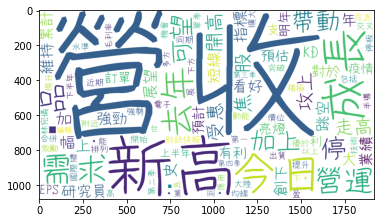

In [ ]:
#以下 文字雲

font_path = ('/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/SNsanafonMugiV260.ttf') # 設定字體格式

wc = wordcloud.WordCloud(background_color='white',
                         margin=2, # 文字間距
                        font_path=font_path, # 設定字體
                         max_words=1000, # 取多少文字在裡面
                         width=1920, height=1080, # 長寬解析度
                         relative_scaling=1 # 詞頻與詞大小關聯性
                         )
# 生成文字雲
# wc.generate_from_frequencies()) # 吃入次數字典資料
mi_dict = dict(zip(df_up['Term'], df_up["TF-IDF*MI"]))
wc.generate_from_frequencies(mi_dict) # 吃入次數字典資料
plt.imshow(wc)
wc.to_file('/content/gdrive/MyDrive/Colab Notebooks/bda2022_hw2_text/limit_up.png')